<a href="https://colab.research.google.com/github/brainopensource/datascience-mvp/blob/ml-analytics-mvp/MVP_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Machine Learning & Analytics para conclusão da Sprint da Pós-Graduação em Ciência de Dados e Analytics (PUC Rio)

# Aluno Lucas da S. Rocha

## Introdução

Este notebook apresenta o desenvolvimento de um Mínimo Produto Viável (MVP) como parte do segundo módulo da Pós-Graduação em Ciência de Dados e Analytics da PUC-Rio. Utilizando dados abertos recentes sobre a produção de petróleo e gás no Brasil, disponibilizados pela Agência Nacional de Petróleo (ANP).

## Definição do Problema

O petróleo continua sendo um ativo estratégico no cenário energético global, afetado por fatores geopolíticos e pela volatilidade dos mercados internacionais. Nesse cenário, o Brasil se destaca como um dos principais produtores mundiais de petróleo e gás natural, tornando sua produção um tema relevante para análises e tomadas de decisão.

O objetivo deste trabalho é investigar a produção de petróleo e gás natural por poço, utilizando dados que abrangem o período de janeiro de 2020 até o primeiro semestre de 2024. Esse recorte captura as tendências mais recentes da indústria e nos permite explorar os fatores que influenciam a produtividade e a eficiência. A partir da aplicação de técnicas de ciência de dados, buscamos identificar padrões produtivos, anomalias e insights que possam otimizar a alocação de recursos e aumentar a eficiência e previsibilidade operacional e financeira.

A riqueza dos dados por poço oferece oportunidades significativas para análises detalhadas. Através de métodos estatísticos e, futuramente, de algoritmos de aprendizado de máquina, pretendemos explorar diversas aplicações, incluindo:    Análise de Eficiência da Produção, Geração de Curvas de Decaimento de Poços,    Classificação de Poços por Eficiência, Previsão da Produção Total por Campo e   Previsão de Royalties.

Essas análises iniciais geram insights valiosos para a gestão e a operação de poços e campos. O pré-processamento dos dados e a análise exploratória formam a base necessária para futuras implementações de machine learning, facilitando o desenvolvimento de modelos preditivos robustos e a criação de ferramentas analíticas que forneçam uma visão mais profunda das dinâmicas de produção. Isso permitirá, no futuro, decisões mais assertivas e embasadas no contexto da produção de petróleo e gás natural no Brasil, à medida que utilizaremos técnicas de aprendizado supervisionado em nosso estudo.


## Código do MVP

### Importação de Bibliotecas

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import hashlib
import warnings
import missingno as msno
import re

### Configuração do Ambiente

Configurações estéticas do pandas para limitar o máximo de linhas, colunas e filtrar avisos.

In [41]:
# Definindo o limite de exibição colunas de dataframe para None (sem limite)
pd.set_option('display.max_columns', 48)

# Definindo o limite de exibição de linhas de dataframe para 48
pd.set_option('display.max_rows', 48)

# Filter warnings
warnings.filterwarnings('ignore')

### Criando lista de URLs de datasets

Conforme sugerido, os dados foram disponibilizados publicamente no repositório do Github e lidos no formato Raw

[Link do Repositório](https://github.com/brainopensource/datascience-mvp)


In [42]:
#url = "https://raw.githubusercontent.com/brainopensource/datascience-mvp/refs/heads/main/datasets/monthly_production_concat/1980_2024_BR_production_data.parquet"
url = "https://github.com/brainopensource/datascience-mvp/raw/refs/heads/ml-analytics-mvp/datasets/monthly_production_concat/1980_2024_BR_production_data.parquet"
df_prod = pd.read_parquet(url)
display(df_prod.head(3))

,estado,bacia,nome_poco_anp,campo,periodo,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,agua_kbd,tempo_producao_hspormes,ano,mes
0,Rio de Janeiro,Campos,3-RJS-159-RJS,PAMPO,2011-01-01,0.293000,0.0,0.293000,0.287652,0.0,0.287652,0.125568,0,2011,1
1,Rio de Janeiro,Campos,7-PM-17D-RJS,PAMPO,2011-01-01,0.196663,0.0,0.196663,0.108893,0.0,0.108893,0.012550,0,2011,1
2,Rio de Janeiro,Campos,6-BRSA-806-RJS,CARATINGA,2011-01-01,13.362645,0.0,13.362645,7.112691,0.0,7.112691,0.033568,0,2011,1


### Transformações de dado

In [43]:
print(df_prod.dtypes)

# Exibir o resultado
print('before', df_prod.columns)

# Substituir acentos e espaços por underscore usando apenas regex
#df_prod.columns = [re.sub(r'[^\w]', '_', col) for col in df_prod.columns]

# Filtrando o DataFrame para o campo MERO
df_campo = df_prod[df_prod['campo'] == 'ALBACORA']

# Obtendo o valor mínimo e máximo de uma coluna específica, por exemplo 'periodo'
min_periodo = df_campo['periodo'].min()
max_periodo = df_campo['periodo'].max()

# Exibindo os valores
print(f"Período mínimo: {min_periodo}")
print(f"Período máximo: {max_periodo}")

display(df_campo.sort_values(by='periodo').head(3))

estado                              object
bacia                               object
nome_poco_anp                       object
campo                               object
periodo                     datetime64[ns]
oleo_kbd                           float64
condensado_kbd                     float64
petroleo_kbd                       float64
gas_natural_mmscf_assoc            float64
gas_natural_mmscf_nassoc           float64
gas_natural_mmscf_total            float64
agua_kbd                           float64
tempo_producao_hspormes              int64
ano                                  int32
mes                                  int32
dtype: object
before Index(['estado', 'bacia', 'nome_poco_anp', 'campo', 'periodo', 'oleo_kbd',
       'condensado_kbd', 'petroleo_kbd', 'gas_natural_mmscf_assoc',
       'gas_natural_mmscf_nassoc', 'gas_natural_mmscf_total', 'agua_kbd',
       'tempo_producao_hspormes', 'ano', 'mes'],
      dtype='object')
Período mínimo: 1987-10-01 00:00:00
Período má

,estado,bacia,nome_poco_anp,campo,periodo,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,agua_kbd,tempo_producao_hspormes,ano,mes
78104,Rio de Janeiro,Campos,1-RJS-297-RJ,ALBACORA,1987-10-01,0.432171,0.0,0.432171,0.140683,0.0,0.140683,0.022745,0,1987,10
78106,Rio de Janeiro,Campos,3-RJS-334-RJ,ALBACORA,1987-10-01,0.738545,0.0,0.738545,0.262374,0.0,0.262374,0.000000,0,1987,10
78105,Rio de Janeiro,Campos,3-RJS-343-RJ,ALBACORA,1987-10-01,0.158260,0.0,0.158260,0.038945,0.0,0.038945,0.000000,0,1987,10


In [44]:
# Certifique-se de que a coluna 'periodo' está em formato datetime
#df_prod['periodo'] = pd.to_datetime(df_prod['periodo'], format='%Y-%m-%d')

# Agrupar por ano e mês, somando a produção média diária de petróleo (KBD) e gás natural (MMSCF)
df_grouped = df_prod.groupby(df_prod['periodo'].dt.to_period('M')).agg(
    producao_media_kbd=('petroleo_kbd', 'sum'),
    producao_media_gas=('gas_natural_mmscf_total', 'sum')
).reset_index()

# Convertendo a coluna 'periodo' de volta para datetime (primeiro dia do mês) para fins de plotagem
df_grouped['periodo'] = df_grouped['periodo'].dt.to_timestamp()

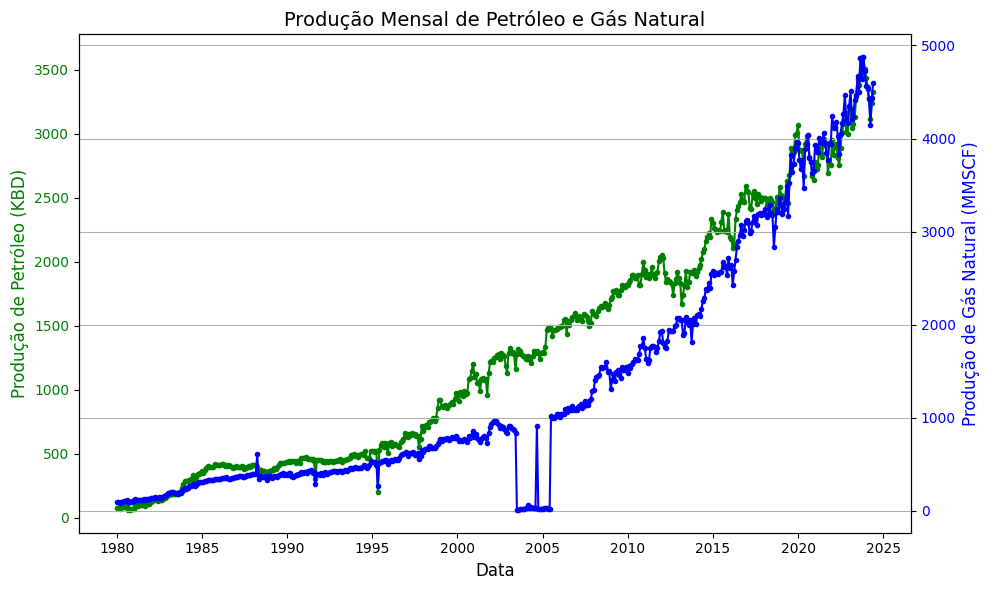

In [45]:
# Plotando os dois gráficos: petróleo e gás no mesmo gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico para a produção de petróleo (KBD)
ax1.plot(df_grouped['periodo'], df_grouped['producao_media_kbd'], marker='.', linestyle='-', color='green', label='Petróleo (KBD)')
ax1.set_xlabel('Data', fontsize=12)
ax1.set_ylabel('Produção de Petróleo (KBD)', fontsize=12, color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Criando o segundo eixo Y para o gás natural
ax2 = ax1.twinx()
ax2.plot(df_grouped['periodo'], df_grouped['producao_media_gas'], marker='.', linestyle='-', color='blue', label='Gás Natural (MMSCF)')
ax2.set_ylabel('Produção de Gás Natural (MMSCF)', fontsize=12, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Título do gráfico
plt.title('Produção Mensal de Petróleo e Gás Natural', fontsize=14)

# Exibir o gráfico
fig.tight_layout()
plt.xticks(rotation=45)
plt.grid(True)

### Curvas Acumuladas

In [46]:
print(df_prod.dtypes)

df_prod_acum = df_prod.copy(deep=True)

estado                              object
bacia                               object
nome_poco_anp                       object
campo                               object
periodo                     datetime64[ns]
oleo_kbd                           float64
condensado_kbd                     float64
petroleo_kbd                       float64
gas_natural_mmscf_assoc            float64
gas_natural_mmscf_nassoc           float64
gas_natural_mmscf_total            float64
agua_kbd                           float64
tempo_producao_hspormes              int64
ano                                  int32
mes                                  int32
dtype: object


### Curvas Acumuladas

In [47]:
# Calcular o número de dias no mês
df_prod_acum['dias_no_mes'] = df_prod_acum['periodo'].dt.days_in_month

# Calcular a produção total no mês (média diária * número de dias no mês)
df_prod_acum['producao_total_mes'] = df_prod_acum['petroleo_kbd'] * df_prod['dias_no_mes']

# Agora, agrupar por poço e calcular a produção acumulada ao longo do tempo
df_prod_acum['producao_acumulada'] = df_prod_acum.groupby('nome_poco_anp')['producao_total_mes'].cumsum()

In [48]:
# Definindo a nova ordem das colunas
colunas_ordenadas = [
    'periodo', 'nome_poco_anp', 'oleo_kbd', 'condensado_kbd', 'petroleo_kbd',
    'gas_natural_mmscf_assoc', 'gas_natural_mmscf_nassoc', 'gas_natural_mmscf_total',
    'agua_kbd', 'estado', 'bacia', 'campo',
    'tempo_producao_hspormes', 'ano', 'mes', 'dias_no_mes',
    'producao_total_mes', 'producao_acumulada']

# Reorganizando as colunas do DataFrame
df_prod_acum = df_prod_acum[colunas_ordenadas]

# Verificando a nova ordem das colunas
df_prod_acum.head()

,periodo,nome_poco_anp,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,agua_kbd,estado,bacia,campo,tempo_producao_hspormes,ano,mes,dias_no_mes,producao_total_mes,producao_acumulada
0,2011-01-01,3-RJS-159-RJS,0.293000,0.0,0.293000,0.287652,0.0,0.287652,0.125568,Rio de Janeiro,Campos,PAMPO,0,2011,1,31,9.083000,9.083000
1,2011-01-01,7-PM-17D-RJS,0.196663,0.0,0.196663,0.108893,0.0,0.108893,0.012550,Rio de Janeiro,Campos,PAMPO,0,2011,1,31,6.096562,6.096562
2,2011-01-01,6-BRSA-806-RJS,13.362645,0.0,13.362645,7.112691,0.0,7.112691,0.033568,Rio de Janeiro,Campos,CARATINGA,0,2011,1,31,414.241980,414.241980
3,2011-01-01,4-RJS-265A-RJS,0.241780,0.0,0.241780,0.177410,0.0,0.177410,0.004931,Rio de Janeiro,Campos,TRILHA,0,2011,1,31,7.495177,7.495177
4,2011-01-01,1-BRSA-594-SPS,17.756235,0.0,17.756235,19.470869,0.0,19.470869,0.000000,São Paulo,Santos,SAPINHOÁ,0,2011,1,31,550.443288,550.443288


### MACHINE LEARNING

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Definindo o campo de interesse
campo_especifico = 'TUPI'

# Filtrando os dados para o campo específico
campo_df = df_prod[df_prod['campo'] == campo_especifico]

# Ordenar os dados pela coluna 'periodo' (data)
campo_df_sorted = campo_df.sort_values(by='periodo')

# Definindo a data de corte para separar treino e teste
# Aqui, vou usar a última data do treino como a data de corte, você pode definir uma data específica
data_corte = campo_df_sorted['periodo'].max() - pd.DateOffset(months=6)  # Por exemplo, 3 meses antes da última data

# Separar os dados em treino e teste com base na data de corte
train_df = campo_df_sorted[campo_df_sorted['periodo'] <= data_corte]
test_df = campo_df_sorted[campo_df_sorted['periodo'] > data_corte]

# Seleção de features e target (usando apenas 'oleo_kbd' como feature)
features = ['oleo_kbd']
target = 'producao_acumulada'

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# Treinar o modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Prever a produção no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Exemplo de previsão para o próximo mês (ajustando o valor de 'oleo_kbd')
novo_mes = {'oleo_kbd': 0.85}  # Aqui você ajusta o valor de 'oleo_kbd' para o próximo mês
X_novo_mes = pd.DataFrame([novo_mes])

# Prever a produção acumulada para o próximo mês
producao_prevista = model.predict(X_novo_mes)
print(f'Produção prevista para o próximo mês: {producao_prevista[0]}')


Mean Squared Error: 752849063.0600162
Produção prevista para o próximo mês: 21983.118776661384


,periodo,nome_poco_anp,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,agua_kbd,estado,bacia,campo,tempo_producao_hspormes,ano,mes,dias_no_mes,producao_total_mes,producao_acumulada
14,2011-01-01,9-BRSA-716-RJS,13.188175,0.0,13.188175,21.049140,0.0,21.049140,0.0,Rio de Janeiro,Santos,TUPI,0,2011,1,31,408.833434,408.833434
30,2011-02-01,9-BRSA-716-RJS,14.871802,0.0,14.871802,24.602713,0.0,24.602713,0.0,Rio de Janeiro,Santos,TUPI,0,2011,2,28,416.410456,825.243890
37,2011-03-01,9-BRSA-716-RJS,14.601435,0.0,14.601435,24.307998,0.0,24.307998,0.0,Rio de Janeiro,Santos,TUPI,0,2011,3,31,452.644479,1277.888369
54,2011-04-01,9-BRSA-716-RJS,21.318976,0.0,21.318976,36.219512,0.0,36.219512,0.0,Rio de Janeiro,Santos,TUPI,0,2011,4,30,639.569265,1917.457634
72,2011-05-01,9-BRSA-716-RJS,28.436432,0.0,28.436432,44.274315,0.0,44.274315,0.0,Rio de Janeiro,Santos,TUPI,0,2011,5,31,881.529389,2798.987023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308880,2011-07-01,3-BRSA-755A-RJS,14.384300,0.0,14.384300,18.831818,0.0,18.831818,0.0,Rio de Janeiro,Santos,TUPI,0,2011,7,31,445.913312,1362.601984
309983,2011-08-01,3-BRSA-755A-RJS,13.431932,0.0,13.431932,17.835753,0.0,17.835753,0.0,Rio de Janeiro,Santos,TUPI,0,2011,8,31,416.389889,1778.991873
310043,2011-09-01,3-BRSA-755A-RJS,11.567170,0.0,11.567170,15.574210,0.0,15.574210,0.0,Rio de Janeiro,Santos,TUPI,0,2011,9,30,347.015109,2126.006982
310959,2011-10-01,3-BRSA-755A-RJS,11.464911,0.0,11.464911,16.949926,0.0,16.949926,0.0,Rio de Janeiro,Santos,TUPI,0,2011,10,31,355.412257,2481.419239


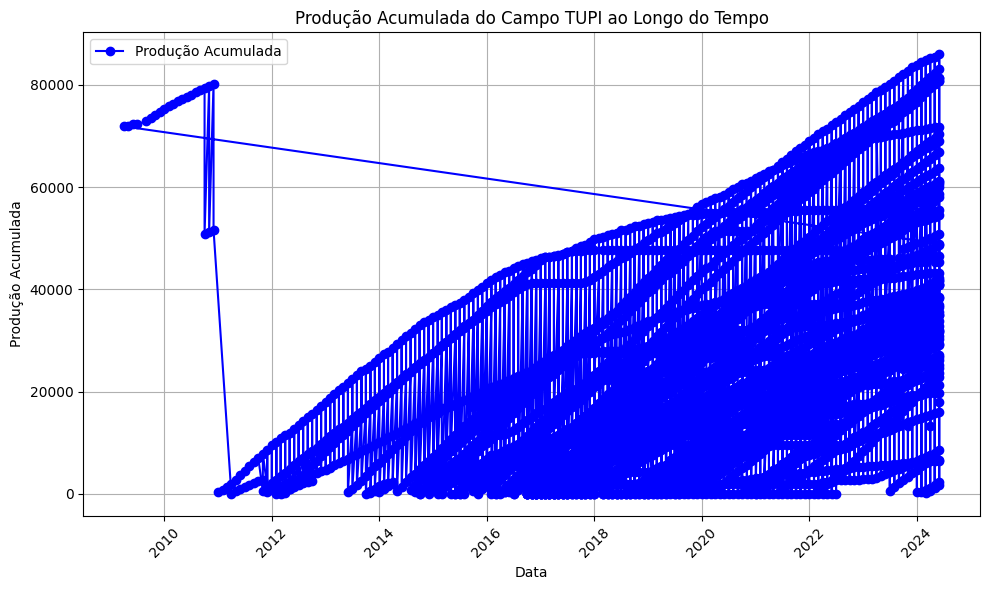

Data de corte para o treino: 2024-03-01 00:00:00


In [51]:
# Filtrando os dados para o campo TUPI
df_tupi = df_prod[df_prod['campo'] == 'TUPI']

# Verificando os primeiros dados do campo TUPI
display(df_tupi)

# Plotando a produção acumulada ao longo do tempo
plt.figure(figsize=(10, 6))
plt.plot(df_tupi['periodo'], df_tupi['producao_acumulada'], marker='o', color='b', label='Produção Acumulada')

# Adicionando título e rótulos
plt.title('Produção Acumulada do Campo TUPI ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Produção Acumulada')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Exibindo o gráfico
plt.tight_layout()
plt.show()

# Verificando a data de corte
data_corte = df_tupi['periodo'].max() - pd.DateOffset(months=3)
print(f'Data de corte para o treino: {data_corte}')

# Verificando se o valor de 2024 está antes ou depois da data de corte
df_2024 = df_tupi[df_tupi['periodo'].dt.year == 2024]

,periodo,campo,producao_acumulada,oleo_kbd
16328,2009-04-01,TUPI,7.189269e+04,1.464677
16398,2009-05-01,TUPI,7.191658e+04,0.770400
16470,2009-06-01,TUPI,7.233039e+04,13.793688
16543,2009-07-01,TUPI,7.236283e+04,1.046452
16689,2009-09-01,TUPI,7.285232e+04,16.316333
...,...,...,...,...
31874,2024-02-01,TUPI,2.478222e+06,744.677291
31946,2024-03-01,TUPI,2.533415e+06,787.704040
32016,2024-04-01,TUPI,2.495046e+06,722.729380
32085,2024-05-01,TUPI,2.572765e+06,755.464600


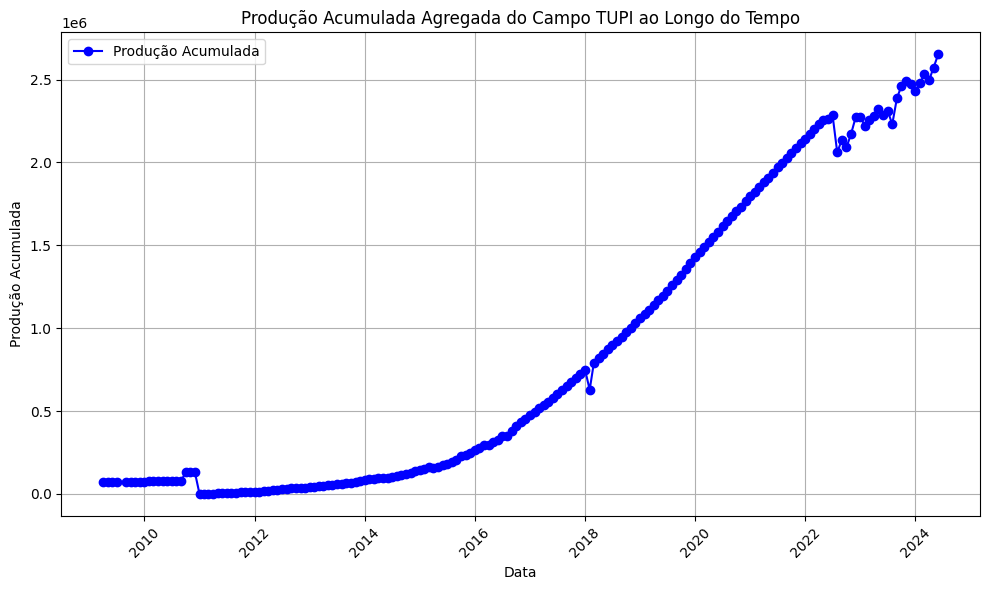

Mean Squared Error: 1380588193213.3953
Produção prevista para o próximo mês: -119405.52684291972


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Agregar os dados por 'periodo' e 'campo', somando as colunas relevantes
df_agregado = df_prod.groupby(['periodo', 'campo'], as_index=False).agg({
    'producao_acumulada': 'sum',  # Somar a produção acumulada
    'oleo_kbd': 'sum'             # Somar a produção de óleo
})

# Filtrar os dados para o campo de interesse (TUPI)
campo_especifico = 'TUPI'
df_tupi_agregado = df_agregado[df_agregado['campo'] == campo_especifico]

# Visualizando os dados agregados do campo TUPI
display(df_tupi_agregado)

# Plotando a produção acumulada agregada ao longo do tempo
plt.figure(figsize=(10, 6))
plt.plot(df_tupi_agregado['periodo'], df_tupi_agregado['producao_acumulada'], marker='o', color='b', label='Produção Acumulada')

# Adicionando título e rótulos
plt.title('Produção Acumulada Agregada do Campo TUPI ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Produção Acumulada')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Exibindo o gráfico
plt.tight_layout()
plt.show()

# Definindo features e target
features = ['oleo_kbd']
target = 'producao_acumulada'

# Dividir os dados em treino e validação, garantindo que a sequência temporal seja mantida
X = df_tupi_agregado[features]
y = df_tupi_agregado[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=False)  # Não embaralhar para manter a sequência temporal

# Treinar o modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Prever a produção no conjunto de validação
y_pred = model.predict(X_val)

# Avaliar o modelo
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error: {mse}')

# Exemplo de previsão para o próximo mês (ajustando o valor de 'oleo_kbd')
novo_mes = {'oleo_kbd': 0.85}  # Aqui você ajusta o valor de 'oleo_kbd' para o próximo mês
X_novo_mes = pd.DataFrame([novo_mes])

# Prever a produção acumulada para o próximo mês
producao_prevista = model.predict(X_novo_mes)
print(f'Produção prevista para o próximo mês: {producao_prevista[0]}')
